# Forecasting store sales with Machine Learning 



## Importing tools

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# Importing model
from xgboost import XGBRegressor

# Importing metric
from sklearn.metrics import mean_squared_log_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Importing data

In [2]:
# Parsing dates when importing data 
train_data = pd.read_csv('data/train.csv', parse_dates=['date'])
test_data = pd.read_csv('data/test.csv', parse_dates=['date'])
stores_data = pd.read_csv('data/stores.csv')
oil_data = pd.read_csv('data/oil.csv', parse_dates=['date']).rename(columns={'dcoilwtico': 'oil_price'})
holidays_data = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])

## Exploring data

### Train data

In [3]:
train_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [4]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
# Understanding our data
train_records = len(train_data)
train_unique_dates = len(train_data.date.unique())
train_unique_stores = len(train_data.store_nbr.unique())
train_unique_family = len(train_data.family.unique())

print(f'records:{train_records}\ndates:{train_unique_dates}\nstores:{train_unique_stores}\nfamilies:{train_unique_family}')

if train_records == train_unique_dates*train_unique_stores*train_unique_family:
    print('The primary key (unique identifier of each record) for the train_data dataframe is: (date, store_nbr, family)')

records:3000888
dates:1684
stores:54
families:33
The primary key (unique identifier of each record) for the train_data dataframe is: (date, store_nbr, family)


Our train_data consists of: 33 different product families that are sold across 54 different stores which give us 1.782 (33x54) independent time series, with a timeframe of 1.684 days (close to 5 years).

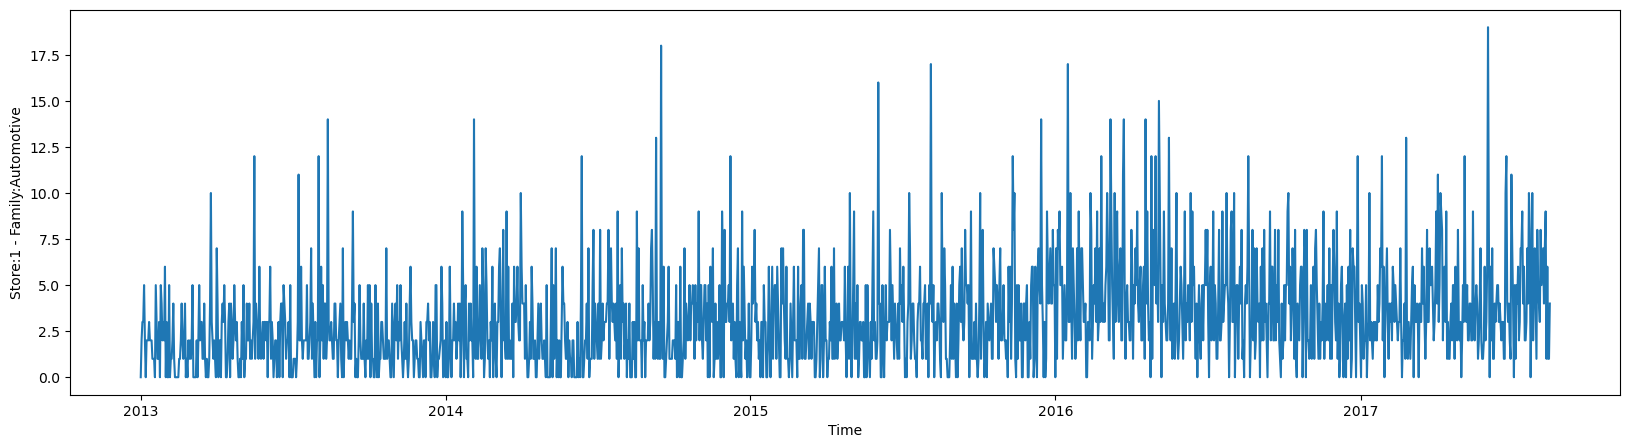

In [6]:
# Let's plot one time series (store_nbr=1 and family='AUTOMOTIVE')
x = train_data.date.unique()
y = train_data.sales[(train_data.store_nbr==1) & (train_data.family=='AUTOMOTIVE')]

plt.figure(figsize=(20,5))
plt.plot(x,y)
plt.xlabel('Time')
plt.ylabel('Store:1 - Family:Automotive');

In [7]:
# Are there missing dates in our train_data?

train_data_start = train_data['date'].min()
train_data_end = train_data['date'].max()

# Generate a date range from start_date to end_date
date_range = pd.date_range(start=train_data_start, end=train_data_end)

# Use the difference between the date_range and the unique dates in the sales data to find missing dates
missing_dates = date_range.difference(train_data['date'])

# Print  missing dates 
print(f"Missing dates: {missing_dates}")

Missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [8]:
# Create multi_index to incorporate missing_dates
multi_index = pd.MultiIndex.from_product([pd.date_range(train_data_start, train_data_end),train_data.store_nbr.unique(),train_data.family.unique()],names=['date','store_nbr','family'],)
train_data = train_data.set_index(['date','store_nbr','family']).reindex(multi_index).reset_index()

# Fill missing values (id, sales, onpromotion)
train_data.id = train_data.id.interpolate(method="linear") 
train_data[['sales','onpromotion']] = train_data[['sales','onpromotion']].fillna(0)

In [9]:
display(train_data)

,date,store_nbr,family,id,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0.000,0.0
1,2013-01-01,1,BABY CARE,1.0,0.000,0.0
2,2013-01-01,1,BEAUTY,2.0,0.000,0.0
3,2013-01-01,1,BEVERAGES,3.0,0.000,0.0
4,2013-01-01,1,BOOKS,4.0,0.000,0.0
...,...,...,...,...,...,...
3008011,2017-08-15,9,POULTRY,3000883.0,438.133,0.0
3008012,2017-08-15,9,PREPARED FOODS,3000884.0,154.553,1.0
3008013,2017-08-15,9,PRODUCE,3000885.0,2419.729,148.0
3008014,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,3000886.0,121.000,8.0


In [10]:
train_data.isna().sum()

date           0
store_nbr      0
family         0
id             0
sales          0
onpromotion    0
dtype: int64

### Test data

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [12]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [13]:
test_records = len(test_data)
test_unique_dates = len(test_data.date.unique())
test_unique_stores = len(test_data.store_nbr.unique())
test_unique_family = len(test_data.family.unique())

print(f'records:{test_records}\ndates:{test_unique_dates}\nstores:{test_unique_stores}\nfamilies:{test_unique_family}')

records:28512
dates:16
stores:54
families:33


Our test_data has the same features as our train data: 33 different product families that are sold across 54 different store.

The test_data timeframe is 16 days

In [14]:
# Are there missing dates in our train_data?

test_data_start = test_data['date'].min()
test_data_end = test_data['date'].max()

# Generate a date range from start_date to end_date
date_range = pd.date_range(start=test_data_start, end=test_data_end)

# Use the difference between the date_range and the unique dates in the sales data to find missing dates
missing_dates = date_range.difference(test_data['date'])

# Print  missing dates 
print(f"Missing dates: {missing_dates}")

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq=None)


### Stores data

In [15]:
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [16]:
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


The stores dataframe provides valuable information to predict future sales sucha as geographic location and cluster (grouping of similar stores).
Since we do not have more information about the 'type' column and therefore can not be interpeted we are going to remove it

In [17]:
stores_data.drop('type', axis=1, inplace=True)

### Oil data

In [18]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1218 non-null   datetime64[ns]
 1   oil_price  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [19]:
oil_data.head()

,date,oil_price
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices. Introducing oil prices to our model can be analyzed as a leading indicator (current changes in oil prices will impact future sales).

In [20]:
# Missing values
oil_data.isna().sum()

date          0
oil_price    43
dtype: int64

In our oil_data we have missing values, probably due to holidays or other reasons where oil is not traded.

Additionally, we have missing rows (incomplete time range) because oil is only traded in business days.

We are going to make two transformations to the oil_data:
* Add weekends to the dataset (at first they will have missing values)
* Fill missing values with a forward fill (for example, the weekends price will be the same than the previous friday).

In [21]:
# Set 'date' column as the index
oil_data.set_index('date', inplace=True)

# Create a date range including all Saturdays and Sundays
complete_timeframe = pd.date_range(start=oil_data.index.min(), end=oil_data.index.max(), freq='D')

# Use the reindex method to include all weekends in oil_data
oil_data = oil_data.reindex(complete_timeframe)

# Forward fill missing values
oil_data.oil_price.ffill(inplace=True)

# Reset the index to keep 'date' as a column
oil_data.reset_index(inplace=True)

# Renaming the column from 'index' to 'date'
oil_data = oil_data.rename(columns={'index': 'date'})

In [22]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1704 non-null   datetime64[ns]
 1   oil_price  1703 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.8 KB


In [23]:
oil_data.isna().sum()

date         0
oil_price    1
dtype: int64

In [24]:
oil_data.head()

,date,oil_price
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


Since we used a forward filling the first value of oil_price is still missing (beacuse it has not a previoud day). 

We are going to fill this value with a backward filling

In [25]:
oil_data.oil_price.bfill(inplace=True)

In [26]:
oil_data.isna().sum()

date         0
oil_price    0
dtype: int64

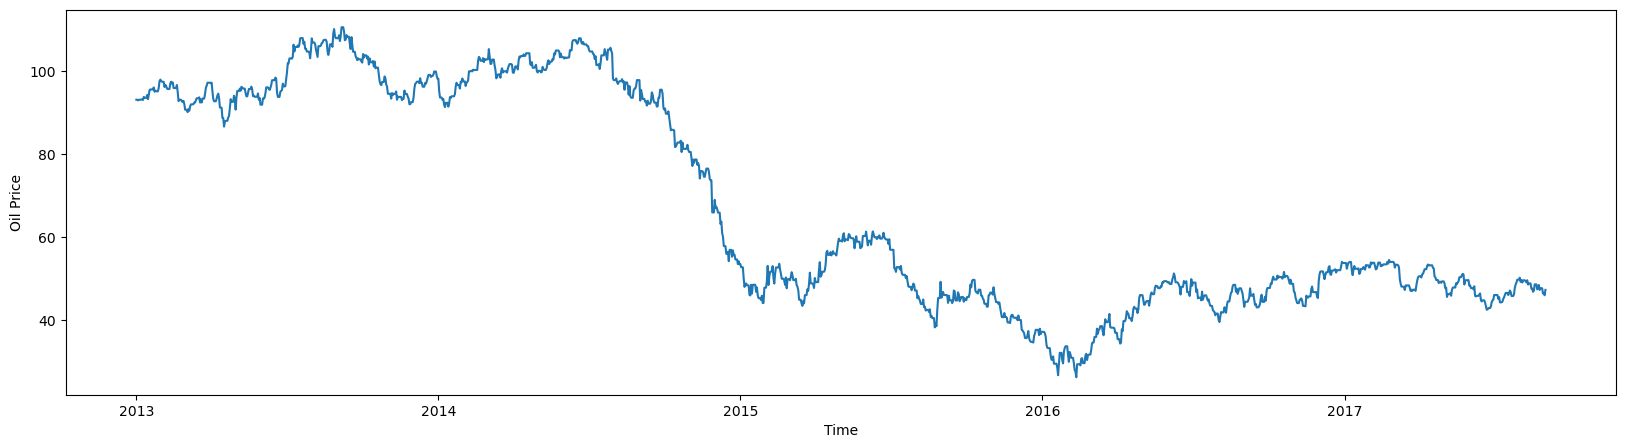

In [27]:
# Let's plot the oil prices
x = oil_data.date
y = oil_data.oil_price

plt.figure(figsize=(20,5))
plt.plot(x,y)
plt.xlabel('Time')
plt.ylabel('Oil Price');

As a macroeconomic variable, a moving average may have a better explanatory power than daily changes. To capture long-term trends we are going to calculate a quarterly moving average.

In [28]:
oil_data['oil_price_3m_avg'] = oil_data['oil_price'].rolling(window=90).mean()

In [29]:
# Creating the new feature introduces a 5% of missing values
oil_data.isna().sum()/len(oil_data)

date                0.00000
oil_price           0.00000
oil_price_3m_avg    0.05223
dtype: float64

In [30]:
# Handling missing values: we are going to use a backfill
oil_data.oil_price_3m_avg.bfill(inplace=True)

### Holidays data

In [31]:
holidays_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [32]:
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


For simplicity we are only going to keep 'National' holidays since they apply to all stores. 

Additionally, we will remove 'transferred' holidays, since a holiday that is transferred officially falls on certain calendar day, but is moved to another date by the government.


In [33]:
holidays_data_filtered = holidays_data[(holidays_data['locale'] == 'National') & (holidays_data['transferred'] != True)]

In [34]:
holidays_data_filtered.head()

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False


For simplicity, we are going to assume that all national holidays have the same impact on store sales. 

Therefore, we are only interested in the dates that have a holiday and not in its type, description, etc.

In [35]:
# Create a boolean column 
holidays_data_filtered['is_holiday'] = 'True'

In [36]:
# Since we are only interested in the date we are going to remove duplicates
holidays_data_filtered = holidays_data_filtered.drop_duplicates(subset='date', keep='first')

## Preprocessing data

In [37]:
def preprocess_data(df):
    # Merging additional information
    df = df.merge(stores_data, on=['store_nbr'], how='left') 
    df = df.merge(oil_data, on=['date'], how='left')
    df = df.merge(holidays_data_filtered[['is_holiday', 'date']], on=['date'], how='left')

    # Fill missing values created when merging feature 'is_holiday'
    df.is_holiday.fillna('False', inplace=True)

    # Transforming non-numerical features into numbers
    for label, content in df.items():
        if pd.api.types.is_object_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()

    # Before making changes in our dataset we are going to create a copy
    # This will allow us to access the categories of category type variables (we are going to input the codes in the dataset)
        original_df = df.copy()

    # Inputting codes of categroy type feature to our dataframe
    for label, content in df.items():
        if pd.api.types.CategoricalDtype.is_dtype(content):
            df[label] = pd.Categorical(content).codes

    # Adding datetime parameters
    df['Year'] = df.date.dt.year
    df['Month'] = df.date.dt.month
    df['Day_of_Week'] = df.date.dt.dayofweek
    df['Day_of_Month'] = df.date.dt.day
    df['Day_of_Year'] = df.date.dt.dayofyear

    # Drop the column 'id' since it does not have explanatory power
    df.drop('id', axis=1, inplace=True)

    return df, original_df

In [38]:
train_data

,date,store_nbr,family,id,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0.000,0.0
1,2013-01-01,1,BABY CARE,1.0,0.000,0.0
2,2013-01-01,1,BEAUTY,2.0,0.000,0.0
3,2013-01-01,1,BEVERAGES,3.0,0.000,0.0
4,2013-01-01,1,BOOKS,4.0,0.000,0.0
...,...,...,...,...,...,...
3008011,2017-08-15,9,POULTRY,3000883.0,438.133,0.0
3008012,2017-08-15,9,PREPARED FOODS,3000884.0,154.553,1.0
3008013,2017-08-15,9,PRODUCE,3000885.0,2419.729,148.0
3008014,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,3000886.0,121.000,8.0


In [39]:
train_data, original_train_data = preprocess_data(train_data)

In [40]:
train_data

,date,store_nbr,family,sales,onpromotion,city,state,cluster,oil_price,oil_price_3m_avg,is_holiday,Year,Month,Day_of_Week,Day_of_Month,Day_of_Year
0,2013-01-01,1,0,0.000,0.0,18,12,13,93.14,94.384778,1,2013,1,1,1,1
1,2013-01-01,1,1,0.000,0.0,18,12,13,93.14,94.384778,1,2013,1,1,1,1
2,2013-01-01,1,2,0.000,0.0,18,12,13,93.14,94.384778,1,2013,1,1,1,1
3,2013-01-01,1,3,0.000,0.0,18,12,13,93.14,94.384778,1,2013,1,1,1,1
4,2013-01-01,1,4,0.000,0.0,18,12,13,93.14,94.384778,1,2013,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,2017-08-15,9,28,438.133,0.0,18,12,6,47.57,47.016111,0,2017,8,1,15,227
3008012,2017-08-15,9,29,154.553,1.0,18,12,6,47.57,47.016111,0,2017,8,1,15,227
3008013,2017-08-15,9,30,2419.729,148.0,18,12,6,47.57,47.016111,0,2017,8,1,15,227
3008014,2017-08-15,9,31,121.000,8.0,18,12,6,47.57,47.016111,0,2017,8,1,15,227


In [41]:
original_train_data

,date,store_nbr,family,id,sales,onpromotion,city,state,cluster,oil_price,oil_price_3m_avg,is_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0.000,0.0,Quito,Pichincha,13,93.14,94.384778,True
1,2013-01-01,1,BABY CARE,1.0,0.000,0.0,Quito,Pichincha,13,93.14,94.384778,True
2,2013-01-01,1,BEAUTY,2.0,0.000,0.0,Quito,Pichincha,13,93.14,94.384778,True
3,2013-01-01,1,BEVERAGES,3.0,0.000,0.0,Quito,Pichincha,13,93.14,94.384778,True
4,2013-01-01,1,BOOKS,4.0,0.000,0.0,Quito,Pichincha,13,93.14,94.384778,True
...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,2017-08-15,9,POULTRY,3000883.0,438.133,0.0,Quito,Pichincha,6,47.57,47.016111,False
3008012,2017-08-15,9,PREPARED FOODS,3000884.0,154.553,1.0,Quito,Pichincha,6,47.57,47.016111,False
3008013,2017-08-15,9,PRODUCE,3000885.0,2419.729,148.0,Quito,Pichincha,6,47.57,47.016111,False
3008014,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,3000886.0,121.000,8.0,Quito,Pichincha,6,47.57,47.016111,False


To understand the codes inputted in our dataframe we can use our train_data copy (original_train_data) that contains the original values

In [42]:
# Exploring 'family'feature (example)
original_train_data.family.cat.categories.to_list()

['AUTOMOTIVE',
 'BABY CARE',
 'BEAUTY',
 'BEVERAGES',
 'BOOKS',
 'BREAD/BAKERY',
 'CELEBRATION',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'HARDWARE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME APPLIANCES',
 'HOME CARE',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MAGAZINES',
 'MEATS',
 'PERSONAL CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'POULTRY',
 'PREPARED FOODS',
 'PRODUCE',
 'SCHOOL AND OFFICE SUPPLIES',
 'SEAFOOD']

From the list above we can see that 

* AUTOMOTIVE = 0, 

* BABY CARE = 1, 

* BEAUTY = 2,

and so on     

## Modelling

Our objective is to predict the future sales for each family (33) sold in each store (54), which gives us 1.782 time series.

We are going to try two different approaches:

1) Assuming that sales for the same families are correlated across stores, we are going to build one model for each family, resulting in 33 models and 54 time series.
   
2) Building one model per unique pair of: (family, store) which results in 1.782 models

### Predicting on validation set (using first strategy)

In [43]:
# As stated before this competition is evaluated on the RMSLE (since it is not available to import it we can calculate it)
def rmsle (y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

In [44]:
# Define cutoff date to split data into training and validation set
cutoff_date = (train_data['date'].max()) - pd.to_timedelta(15, unit='D')  # 15 days to make it comparable to our test_data

# Split train_data into a train and validation set
train_set = train_data[train_data.date < cutoff_date]
val_set = train_data[train_data.date >= cutoff_date]

In [45]:
# List of unique families
family_list = train_data['family'].unique().tolist()

In [46]:
# The dictionaries where we are going to append 33 dataframes, one for each family
train_set_dict = {}
val_set_dict = {}

In [47]:
# Looping through each set to create the corresponding dataframes
for family in family_list:
    family_df = train_set[train_set['family'] == family].copy()
    # Defining key,value in our empty dictionary
    train_set_dict[f'family_{family}'] = family_df 

for family in family_list:
    family_df = val_set[val_set['family'] == family].copy()
    # Defining key,value in our empty dictionary
    val_set_dict[f'family_{family}'] = family_df

# Setting 'date' as index
for i in range(33):
    key = f'family_{i}'
    train_set_dict[key].set_index('date', drop=True, inplace=True)
    val_set_dict[key].set_index('date', drop=True, inplace=True)

In [48]:
# Create function to forecast
def recurssive_forecasting1(train_df, test_df):

    # Define the number of steps to forecast recursively
    n_steps = 16
    
    # Define lagged and rolling window features
    lag_features = [1, 7, 30]
    roll_features = [7, 30]
    
    # Create lagged and rolling features
    def create_features(df, lag_features, roll_features):
        
        for lag in lag_features:
            df[f'lag_{lag}'] = df.groupby(['store_nbr']).sales.shift(lag)
    
        for roll in roll_features:
            df[f'roll_avg_{roll}'] = df.groupby(['store_nbr']).sales.transform(lambda x: x.rolling(window=roll).mean())
            df[f'roll_std_{roll}'] = df.groupby(['store_nbr']).sales.transform(lambda x: x.rolling(window=roll).std())
        
        return df.dropna()

    # Initialize model
    model = XGBRegressor()
    
    # Create empty dataframe for predictions
    predictions_list = []

    for i in range(n_steps):

        # Create features on current training data
        train_features = create_features(train_df, lag_features, roll_features)

        # Define X (features) and y (target)
        X_train = train_features.drop('sales', axis=1)
        y_train = train_features['sales']

        # Train model
        model.fit(X_train, y_train)

        # Make a one-step forecast
        # Take into account all the train_set plus the first day of the val_set
        updated_train_df = pd.concat([train_df, test_df[(i)*54:(i+1)*54]], axis=0)
        updated_train_features = create_features(updated_train_df, lag_features, roll_features)

        # Define X_test
        X_test = updated_train_features.drop('sales', axis=1).tail(54)

        # Predicting values on X_val and making sure there are no predicted negative sales (if negative, they will be assigned a 0)
        y_preds = model.predict(X_test)
        y_preds[y_preds < 0] = 0  

        # Replacing actual sales with predicted sales in our val_set and adding it to our train_set
        test_df['sales'][(i)*54:(i+1)*54] = y_preds
        train_df = pd.concat([train_df, test_df[(i)*54:(i+1)*54]], axis=0)

        # Appending predictions to predictions_df 
        y_preds =  y_preds.tolist()
        predictions_list.append(y_preds)

    # Transforming predtictions_list to a dataframe to make comparable with val_set
    predictions_df = pd.DataFrame(predictions_list, index=test_df.index.unique(), columns=range(1,55))
    predictions_df = predictions_df.stack()
    predictions_df = predictions_df.reset_index(level=1, drop=True).to_frame().rename(columns={0: 'preds'})
    predictions_df['store_nbr'] = test_df['store_nbr']
    predictions_df['family'] = test_df['family']

    return predictions_df

In [49]:
# Creating empty dictionary where we are going to append 33 dataframes that contain a prediction_df for each family
val_predictions = {}

# Looping through each predictions_df
for i in range(33):
    key = f'family_{i}'    
    val_predictions[key] = recurssive_forecasting1(train_set_dict[key], val_set_dict[key])

In [50]:
# Create function to make prediction comparable to test_data
def format_predictions(predictions_dict, test_df):
    # Get all predictions into a list
    predictions_list = list(predictions_dict.values())

    # Merge all predictions into one dataframe
    predictions_df = pd.concat(predictions_list, axis=0)

    # Merge predictions with test_df
    merged_df = pd.merge(test_df, predictions_df, on=['date', 'store_nbr', 'family'], how='left')

    # Extract predictions
    final_predictions = merged_df.preds

    return final_predictions  

In [51]:
preds_df = format_predictions(val_predictions,val_set)

In [52]:
rmsle(preds_df,val_set.sales)

0.37408203787221483

## Preprocessing test data

We need to preprocess our test_data (the same way we did with our train_data) to make predictions

In [53]:
test_data

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [54]:
test_data, original_test_data = preprocess_data(test_data)

In [55]:
test_data

,date,store_nbr,family,onpromotion,city,state,cluster,oil_price,oil_price_3m_avg,is_holiday,Year,Month,Day_of_Week,Day_of_Month,Day_of_Year
0,2017-08-16,1,0,0,18,12,13,46.80,46.987667,0,2017,8,2,16,228
1,2017-08-16,1,1,0,18,12,13,46.80,46.987667,0,2017,8,2,16,228
2,2017-08-16,1,2,2,18,12,13,46.80,46.987667,0,2017,8,2,16,228
3,2017-08-16,1,3,20,18,12,13,46.80,46.987667,0,2017,8,2,16,228
4,2017-08-16,1,4,0,18,12,13,46.80,46.987667,0,2017,8,2,16,228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,28,1,18,12,6,47.26,46.631111,0,2017,8,3,31,243
28508,2017-08-31,9,29,0,18,12,6,47.26,46.631111,0,2017,8,3,31,243
28509,2017-08-31,9,30,1,18,12,6,47.26,46.631111,0,2017,8,3,31,243
28510,2017-08-31,9,31,9,18,12,6,47.26,46.631111,0,2017,8,3,31,243


#### Adding 'sales' column to our test data

We are going to need it when using recurssive forecasting (we are going to fill this column with predictions)

In [56]:
test_data['sales'] = 0

In [57]:
# We need to have our features in the same order as our train data
column_order = train_data.columns
test_data = test_data[column_order]

### Predicting on test data (using first strategy)

In [58]:
# Split our train_data and test_data in 33 dataframes (one for each family)
train_dict = {}
test_dict = {}

# Looping through each set to create the corresponding dataframes
for family in family_list:
    family_df = train_data[train_data['family'] == family].copy()
    # Defining key,value in our empty dictionary
    train_dict[f'family_{family}'] = family_df

for family in family_list:
    family_df = test_data[test_data['family'] == family].copy()
    # Defining key,value in our empty dictionary
    test_dict[f'family_{family}'] = family_df

# Setting 'date' as index
for i in range(33):
    key = f'family_{i}'
    train_dict[key].set_index('date', drop=True, inplace=True)
    test_dict[key].set_index('date', drop=True, inplace=True)

In [59]:
# Creating empty dictionary where we are going to append 33 dataframes that contain a prediction_df for each family
test_predictions = {}

# Looping through each predictions_df
for i in range(33):
    key = f'family_{i}'    
    test_predictions[key] = recurssive_forecasting1(train_dict[key], test_dict[key])

In [60]:
# Making predictions comparable to our test_data
test_preds = format_predictions(test_predictions,test_data)

In [61]:
# Create a function to make predictions ready to be uploaded to Kaggle
def kaggle_upload(predictions_df):
    # The format of the dataframe that should be uploaded to Kaggle has a column called 'id' that starts at 3000888 and increases by 1
    id = pd.DataFrame([3000888 + i  for i in range(len(predictions_df))])
    predictions_df = pd.merge(id, predictions_df, left_index=True, right_index=True, how='right')
    predictions_df.rename(columns={'preds':'sales', 0:'id'}, inplace=True)

    # Submit predictions
    predictions_df.to_csv('data/submission.csv', index=False)

In [62]:
kaggle_upload(test_preds)

### Predicting on test data (using second strategy)

In [63]:
# List of unique families and stores
family_list = train_data['family'].unique().tolist()
store_list = train_data['store_nbr'].unique().tolist()

In [64]:
# Split our train_data and test_data in 1.782 dataframes (one for each pair: family and store)
train_dict = {}
test_dict = {}

# Looping through each set to create the corresponding dataframes and setting index to: 'date', 'store' and 'family'
for family in family_list:
    for store in store_list:
        family_df = train_data[(train_data['family'] == family) & (train_data['store_nbr'] == store)].copy()
        # Defining key,value in our empty dictionary
        key = f'family_{family}_store_{store}'
        train_dict[key] = family_df
        train_dict[key].set_index(['date', 'store_nbr', 'family'], drop=True, inplace=True)

for family in family_list:
    for store in store_list:
        family_df = test_data[(test_data['family'] == family) & (test_data['store_nbr'] == store)].copy()
        # Defining key,value in our empty dictionary
        key = f'family_{family}_store_{store}'
        test_dict[key] = family_df
        test_dict[key].set_index(['date', 'store_nbr', 'family'], drop=True, inplace=True)

We need to modify our recurssive_forecasting1 function since it was thought to predict with one dataframe per family as input.

In [65]:
def recurssive_forecasting2(train_df, test_df):

    # Define the number of steps to forecast recursively
    n_steps = 16
    
    # Define lagged and rolling window features
    lag_features = [1, 7, 30]
    roll_features = [7, 30]
    
    # Create lagged and rolling features
    def create_features(df, lag_features, roll_features):
        
        for lag in lag_features:
            df[f'lag_{lag}'] = df['sales'].shift(lag)
    
        for roll in roll_features:
            df[f'roll_avg_{roll}'] = df['sales'].rolling(window=roll).mean()
            df[f'roll_std_{roll}'] = df['sales'].rolling(window=roll).std()
        
        return df.dropna()

    # Initialize model
    model = XGBRegressor()
    
    # Create empty dataframe for predictions
    predictions_list = []

    for i in range(n_steps):

        # Create features on current training data
        train_features = create_features(train_df, lag_features, roll_features)

        # Define X (features) and y (target)
        X_train = train_features.drop('sales', axis=1)
        y_train = train_features['sales']

        # Train model
        model.fit(X_train, y_train)

        # Make a one-step forecast
        # Take into account all the train_set plus the first day of the val_set
        updated_train_df = pd.concat([train_df, test_df[(i):(i+1)]], axis=0)
        updated_train_features = create_features(updated_train_df, lag_features, roll_features)

        # Define X_test
        X_test = updated_train_features.drop('sales', axis=1).tail(1)

        # Predicting values on X_val and making sure there are no predicted negative sales (if negative, they will be assigned a 0)
        y_preds = model.predict(X_test)
        y_preds[y_preds < 0] = 0 

        # Replacing actual sales with predicted sales in our val_set and adding it to our train_set
        test_df['sales'][(i):(i+1)] = y_preds
        train_df = pd.concat([train_df, test_df[(i):(i+1)]], axis=0)

        # Appending predictions to predictions_df 
        y_preds =  y_preds.tolist()
        predictions_list.append(y_preds)
    
    # Transforming predtictions_list to a dataframe to make comparable with test_set
    predictions_df = pd.DataFrame(predictions_list, columns=['preds'])
    predictions_df['date'] = test_df.index.get_level_values('date')
    predictions_df['store_nbr'] = test_df.index.get_level_values('store_nbr')
    predictions_df['family'] = test_df.index.get_level_values('family')

    return predictions_df

In [66]:
# Creating empty dictionary where we are going to append 1.782 dataframes that contain a prediction_df for each family,store
test_predictions = {}

# Define the range of values to iterate over
family_range = range(33)
store_range = range(1, 55)

# Use tqdm to create a progress bar
for family in family_range:
    for store in store_range:
        key = f'family_{family}_store_{store}'   
        # Make predictions
        test_predictions[key] = recurssive_forecasting2(train_dict[key], test_dict[key])

In [67]:
# Making predictions comparable to our test_data
test_preds = format_predictions(test_predictions,test_data)

In [68]:
kaggle_upload(test_preds)

Our second strategy performed better, resulting in a lower RMSLE (0.81 vs 0.68)

## Further work

1) Use well-known python libraries for time-series like Darts or Temporian
2) Explore performance of different models, such as: CatBoost and LightGBM
3) Perform hyperparameter tuning using Randomized Search or Optuna
4) Try direct forecasting approach